# Project 3 - Sentiment Analysis of Elon Musk using YouTube Comments

## Part 2 - Establishing Ground Truth and Exploratory Data Analysis

## 1. Establishing Ground Truth

In order to create a sentiment analysis model, we need to train it with our YouTube data. However, there is no ground truth that tells us which comments have a positive and negative sentiment.

Thus, we will use a Lexicon that has already been trained for sentiment analysis:
1. Run an established model (the VADER sentiment analysis tool in the Natural Language Toolkit) on the comments.
2. Because we are purely concentrating on negative comments, we will use the model to classify whether the comment is negative or not (1 for negative, 0 otherwise)
3. Pick out 100 comments at random, and manually label them by their sentiment (ie. negative or not negative).
4. Compare the manually labelled comments with the established model to see its recall and accuracy score.
5. If the scores are reasonably high, we will use that model as the ground truth for all the comments.
6. From there, we will train our model using this ground truth.

### 1.1 Running VADER Sentiment Analysis Tool

In [1]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

import re
import pickle

In [2]:
# Loading dataset from previous notebook
with open('../data/01_Cleaned_Data.pickle', 'rb') as file:
    df = pickle.load(file)

In [3]:
# Using the VADER Sentiment Analysis Tool on the comments
sia = SIA()
results = []

for line in df['text']:
    # Check if the 'Post Body' value is a string or NaN
    if isinstance(line, str):
        pol_score = sia.polarity_scores(line)
    else:
        # If 'Post Body' is NaN, assign a default score of zero
        pol_score = {'compound': 0.0, 'neg': 0.0, 'neu': 0.0, 'pos': 0.0}
        
    pol_score['comment'] = line
    results.append(pol_score)

print(results[:3])

[{'neg': 0.0, 'neu': 0.816, 'pos': 0.184, 'compound': 0.2023, 'comment': 'I see I ribbit playing out in the next 50 years'}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0, 'comment': "67 Million Joe Rogan's Watched this video ðŸ˜…"}, {'neg': 0.0, 'neu': 0.621, 'pos': 0.379, 'compound': 0.7269, 'comment': 'Joe, giant carbon filters are called trees they do a pretty good job.'}]


In [4]:
# Create a DataFrame
sentiment_df = pd.DataFrame.from_records(results)
sentiment_df.head()

neg    neu    pos  compound  \
0  0.000  0.816  0.184    0.2023   
1  0.000  1.000  0.000    0.0000   
2  0.000  0.621  0.379    0.7269   
3  0.025  0.817  0.158    0.8678   
4  0.000  0.842  0.158    0.4588   

                                             comment  
0    I see I ribbit playing out in the next 50 years  
1        67 Million Joe Rogan's Watched this video ðŸ˜…  
2  Joe, giant carbon filters are called trees the...  
3  The Sun is not actually on fire in the same wa...  
4  If anyone cares to look, Elon Musk wiki still ...

In [5]:
# Create a column called 'is_negative'
sentiment_df['is_negative'] = 0
# Assign it to a binary score where if the compount score is less than zero, it is negative
sentiment_df.loc[sentiment_df['compound'] < 0, 'is_negative'] = 1
sentiment_df.loc[sentiment_df['compound'] >= 0, 'is_negative'] = 0
sentiment_df.head()

neg    neu    pos  compound  \
0  0.000  0.816  0.184    0.2023   
1  0.000  1.000  0.000    0.0000   
2  0.000  0.621  0.379    0.7269   
3  0.025  0.817  0.158    0.8678   
4  0.000  0.842  0.158    0.4588   

                                             comment  is_negative  
0    I see I ribbit playing out in the next 50 years            0  
1        67 Million Joe Rogan's Watched this video ðŸ˜…            0  
2  Joe, giant carbon filters are called trees the...            0  
3  The Sun is not actually on fire in the same wa...            0  
4  If anyone cares to look, Elon Musk wiki still ...            0

In [6]:
# Creating a new DataFrame from the comment and 'is_negative' column
df2 = sentiment_df[['comment', 'is_negative']]

In [7]:
df2.head()

comment  is_negative
0    I see I ribbit playing out in the next 50 years            0
1        67 Million Joe Rogan's Watched this video ðŸ˜…            0
2  Joe, giant carbon filters are called trees the...            0
3  The Sun is not actually on fire in the same wa...            0
4  If anyone cares to look, Elon Musk wiki still ...            0

In [8]:
# Seeing the breakdown of 'is_negative' values
df2['is_negative'].value_counts()

0    34032
1    10283
Name: is_negative, dtype: int64

There are three times more 'non-negative' comments than 'negative' comments (ie. class imbalance). We will need to address that when training the model.

In [9]:
# Dropping 'text' column from the original DataFrame to prevent overlap with 'comment' column from new DataFrame
df.drop(columns = 'text', inplace = True)

In [10]:
# Reset index for both DataFrames
df.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)

# Concatenate the two DataFrames along the columns
df = pd.concat([df, df2], axis=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44315 entries, 0 to 44314
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   author              44315 non-null  object             
 1   published_at        44315 non-null  datetime64[ns, UTC]
 2   like_count          44315 non-null  int64              
 3   video_title         44315 non-null  object             
 4   video_published_at  44315 non-null  datetime64[ns, UTC]
 5   is_english          44315 non-null  int64              
 6   comment_length      44315 non-null  int64              
 7   comment_word_count  44315 non-null  int64              
 8   comment             44315 non-null  object             
 9   is_negative         44315 non-null  int64              
dtypes: datetime64[ns, UTC](2), int64(5), object(3)
memory usage: 3.4+ MB


In [12]:
df

author              published_at  like_count  \
0              Ronnie Howard 2023-08-08 12:46:01+00:00           0   
1      Daham Kumarapathirana 2023-08-08 02:09:05+00:00           0   
2               Beau Johnson 2023-08-07 09:54:50+00:00           0   
3                ProphetKilo 2023-08-06 23:22:43+00:00           0   
4                   Khadulau 2023-08-06 22:35:45+00:00           0   
...                      ...                       ...         ...   
44310           Arm Wrestler 2018-10-06 19:01:01+00:00           0   
44311                EL34XYZ 2018-10-06 18:54:27+00:00         156   
44312                  River 2018-10-06 18:52:02+00:00           0   
44313              Gaz Potts 2018-10-06 18:42:25+00:00           0   
44314       The Prime Remedy 2018-10-06 18:37:32+00:00           0   

                                  video_title        video_published_at  \
0      Joe Rogan Experience #1169 - Elon Musk 2018-09-07 08:12:43+00:00   
1      Joe Rogan Experience #1169 - Elon Musk 2018-09-07 08:12:43+00:00   
2      Joe Rogan Experience #1169 - Elon Musk 2018-09-07 08:12:43+00:00   
3      Joe Rogan Experience #1169 - Elon Musk 2018-09-07 08:12:43+00:00   
4      Joe Rogan Experience #1169 - Elon Musk 2018-09-07 08:12:43+00:00   
...                                       ...                       ...   
44310  Joe Rogan Experience #1169 - Elon Musk 2018-09-07 08:12:43+00:00   
44311  Joe Rogan Experience #1169 - Elon Musk 2018-09-07 08:12:43+00:00   
44312  Joe Rogan Experience #1169 - Elon Musk 2018-09-07 08:12:43+00:00   
44313  Joe Rogan Experience #1169 - Elon Musk 2018-09-07 08:12:43+00:00   
44314  Joe Rogan Experience #1169 - Elon Musk 2018-09-07 08:12:43+00:00   

       is_english  comment_length  comment_word_count  \
0               1              47                  11   
1               1              43                   8   
2               1              69                  13   
3               1             450                  81   
4               1              95                  17   
...           ...             ...                 ...   
44310           1              33                   6   
44311           1             328                  55   
44312           1              67                  13   
44313           1             186                  37   
44314           1              44                   8   

                                                 comment  is_negative  
0        I see I ribbit playing out in the next 50 years            0  
1            67 Million Joe Rogan's Watched this video ðŸ˜…            0  
2      Joe, giant carbon filters are called trees the...            0  
3      The Sun is not actually on fire in the same wa...            0  
4      If anyone cares to look, Elon Musk wiki still ...            0  
...                                                  ...          ...  
44310                  I rather be pessimistic and WRONG            1  
44311  Wow, jaw dropping interview. It's fascinating ...            0  
44312  A day later joe â€œElon weird, I donâ€™t understan...            1  
44313  I watched all this earlier I couldn't stop it ...            0  
44314       Lol at the description.  Elon got his magnet            0  

[44315 rows x 10 columns]

### 1.2 Manual Labeling

We will take out 100 comments to label manually.

In [13]:
X_main, X_handpicked, y_main, y_test = train_test_split(df['comment'], df['is_negative'], test_size = 100, 
                                                       random_state = 42)

In [14]:
#Exporting the samples for hand labeling
X_handpicked.to_csv('../data/02_Handpicked_Sample.csv',index=False)

At this point, I hand-label the sample on Google Sheets, before importing the labelled file.

In [26]:
#Importing hand labeled data for evaluation of VADER lexicon
X_hand_labeled=pd.read_csv('../data/02_Handpicked_Sample_Labelled.csv')

In [27]:
y_test.reset_index(drop = True, inplace = True)

In [28]:
X_hand_labeled['is_negative'].reset_index(drop = True, inplace = True)

In [29]:
#Evaluation using recall and accuracy scores
print(f"Recall score of VADER model:{recall_score(X_hand_labeled['is_negative'],y_test)}")
print(f"Accuracy score of VADER model:{accuracy_score(X_hand_labeled['is_negative'],y_test)}")

Recall score of VADER model:0.8
Accuracy score of VADER model:0.84


The recall and accuracy score of the model is mildly strong. Thus, we will use the VADER Sentiment Analysis Tool as a ground truth, and use it to label if a comment is positive or negative across all the rows.

## 2. EDA

### 2.1 Summary Statistics

In [44]:
df.describe(include = 'all')

/var/folders/w4/0rkrlv1d2cg4g7rbby5yb_tr0000gn/T/ipykernel_87694/4220128335.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include = 'all')
/var/folders/w4/0rkrlv1d2cg4g7rbby5yb_tr0000gn/T/ipykernel_87694/4220128335.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include = 'all')


author               published_at    like_count  \
count           44315                      44315  44315.000000   
unique          36775                      44307           NaN   
top     Johnice Toler  2022-04-09 23:45:54+00:00           NaN   
freq              145                          2           NaN   
first             NaN  2018-10-06 18:37:32+00:00           NaN   
last              NaN  2023-08-08 12:46:01+00:00           NaN   
mean              NaN                        NaN     15.486810   
std               NaN                        NaN    287.375593   
min               NaN                        NaN      0.000000   
25%               NaN                        NaN      0.000000   
50%               NaN                        NaN      0.000000   
75%               NaN                        NaN      1.000000   
max               NaN                        NaN  51623.000000   

                                   video_title         video_published_at  \
count                                    44315                      44315   
unique                                       1                          1   
top     Joe Rogan Experience #1169 - Elon Musk  2018-09-07 08:12:43+00:00   
freq                                     44315                      44315   
first                                      NaN  2018-09-07 08:12:43+00:00   
last                                       NaN  2018-09-07 08:12:43+00:00   
mean                                       NaN                        NaN   
std                                        NaN                        NaN   
min                                        NaN                        NaN   
25%                                        NaN                        NaN   
50%                                        NaN                        NaN   
75%                                        NaN                        NaN   
max                                        NaN                        NaN   

        is_english  comment_length  comment_word_count  \
count      44315.0    44315.000000        44315.000000   
unique         NaN             NaN                 NaN   
top            NaN             NaN                 NaN   
freq           NaN             NaN                 NaN   
first          NaN             NaN                 NaN   
last           NaN             NaN                 NaN   
mean           1.0      134.250750           24.598827   
std            0.0      250.520171           44.653029   
min            1.0        0.000000            0.000000   
25%            1.0       43.000000            8.000000   
50%            1.0       76.000000           14.000000   
75%            1.0      139.000000           26.000000   
max            1.0     9712.000000         1779.000000   

                                   comment   is_negative  
count                                44315  44315.000000  
unique                               44311           NaN  
top     "I want to be a magnet" -Elon Musk           NaN  
freq                                     2           NaN  
first                                  NaN           NaN  
last                                   NaN           NaN  
mean                                   NaN      0.232043  
std                                    NaN      0.422141  
min                                    NaN      0.000000  
25%                                    NaN      0.000000  
50%                                    NaN      0.000000  
75%                                    NaN      0.000000  
max                                    NaN      1.000000

*Interpretation: This gives us a quick understanding of the DataFrame. What I found interesting was that there are massive outliers in terms of magnitude when it comes to the like count, comment length, and comment word count.*

### 2.2 Word Cloud

We will start off by creating a simple wordcloud of the comments.

In [30]:
df.head()

author              published_at  like_count  \
0          Ronnie Howard 2023-08-08 12:46:01+00:00           0   
1  Daham Kumarapathirana 2023-08-08 02:09:05+00:00           0   
2           Beau Johnson 2023-08-07 09:54:50+00:00           0   
3            ProphetKilo 2023-08-06 23:22:43+00:00           0   
4               Khadulau 2023-08-06 22:35:45+00:00           0   

                              video_title        video_published_at  \
0  Joe Rogan Experience #1169 - Elon Musk 2018-09-07 08:12:43+00:00   
1  Joe Rogan Experience #1169 - Elon Musk 2018-09-07 08:12:43+00:00   
2  Joe Rogan Experience #1169 - Elon Musk 2018-09-07 08:12:43+00:00   
3  Joe Rogan Experience #1169 - Elon Musk 2018-09-07 08:12:43+00:00   
4  Joe Rogan Experience #1169 - Elon Musk 2018-09-07 08:12:43+00:00   

   is_english  comment_length  comment_word_count  \
0           1              47                  11   
1           1              43                   8   
2           1              69                  13   
3           1             450                  81   
4           1              95                  17   

                                             comment  is_negative  
0    I see I ribbit playing out in the next 50 years            0  
1        67 Million Joe Rogan's Watched this video ðŸ˜…            0  
2  Joe, giant carbon filters are called trees the...            0  
3  The Sun is not actually on fire in the same wa...            0  
4  If anyone cares to look, Elon Musk wiki still ...            0

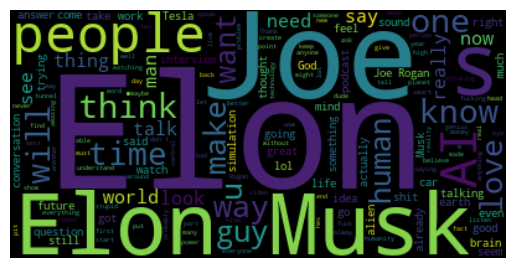

In [31]:
# Start with one review:
text = df['comment'].str.cat()

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

*Interpretation: We see that the words Elon and Joe (the interviewer) being the biggest words in the word cloud. Let us investigate deeper with a bar chart.*

### 2.3 Top 10 Words

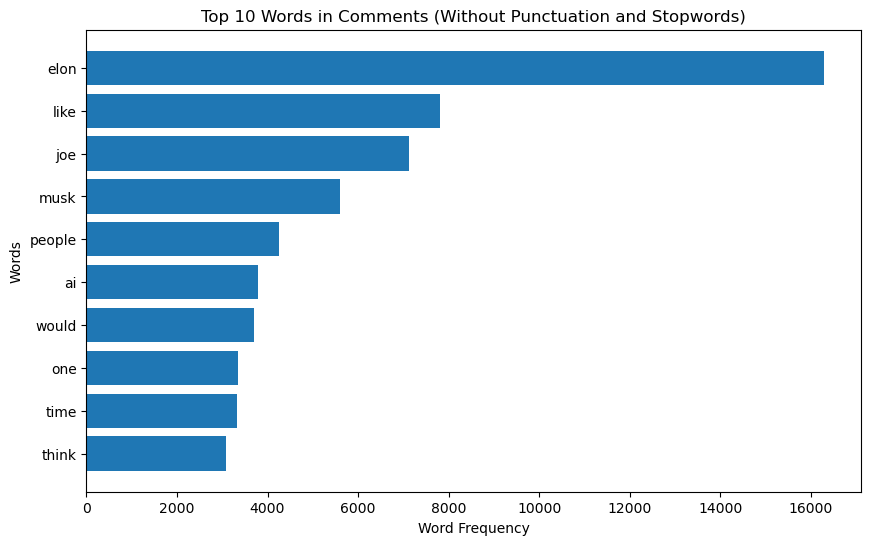

In [32]:
# Tokenize the words in the 'comment' column, remove punctuation, and filter stopwords
stop_words = set(stopwords.words('english'))
translator = str.maketrans('', '', string.punctuation)

all_words = []
for comment in df['comment']:
    words = word_tokenize(comment.lower())
    filtered_words = [word.translate(translator) for word in words if word.isalpha() and word not in stop_words]
    all_words.extend(filtered_words)

# Calculate word frequencies
word_freq = Counter(all_words)

# Get the top 10 words
top_words = word_freq.most_common(10)

# Extract word labels and frequencies for plotting
word_labels = [word[0] for word in top_words]
word_frequencies = [word[1] for word in top_words]

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(word_labels, word_frequencies)
plt.xlabel('Word Frequency')
plt.ylabel('Words')
plt.title('Top 10 Words in Comments (Without Punctuation and Stopwords)')
plt.gca().invert_yaxis()  # Invert y-axis to have the most common word on top
plt.show()

*Interpretation: Indeed the word 'elon' is the most popular, and 'joe' is in third place while 'musk' is in fourth. Most of the other words are not meaningful except perhaps the words 'AI' and 'think'.*

### 2.4 Scatterplot between Comment Length and Comment Word Count

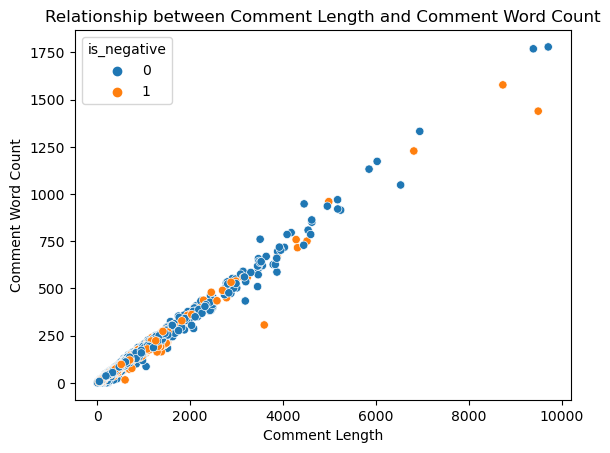

In [33]:
# Plot the scatterplot between comment length and comment word count
sns.scatterplot(data = df, x = 'comment_length', y = 'comment_word_count', hue = 'is_negative')
plt.xlabel('Comment Length')
plt.ylabel('Comment Word Count')
plt.title('Relationship between Comment Length and Comment Word Count');

*Interpretation: We see a strong positive relationship between comment length and comment word count, and whether the comment is negative or not doesn't seem to be related to them.*

### 2.5 Distribution of Dates of Comments

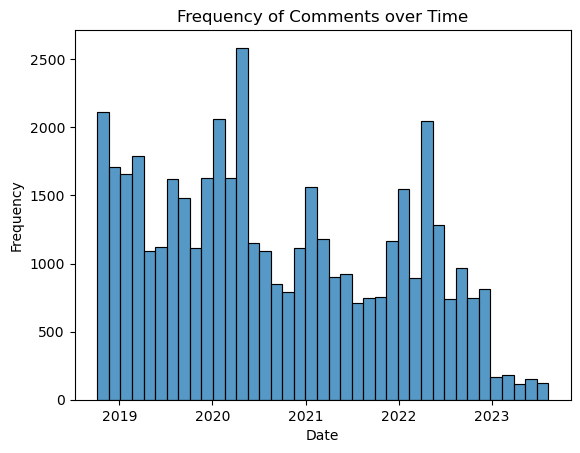

In [34]:
# Plot a histogram showing the distribution of comments in terms of date
sns.histplot(data = df, x = 'published_at')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Frequency of Comments over Time');

*Interpretation: In terms of frequency of comments over time, we see that the comments have been on a mild decreasing trend, with 2023 being much lower than the other years. However, this does not necessarily reflect the full data, as we only got 50,000 comments out of the over 100,000 comments in total. We might have just gotten comments that are older instead.*

### 2.6 Distribution of Negative and Non-Negative Comments

In [35]:
distribution = df2['is_negative'].value_counts()

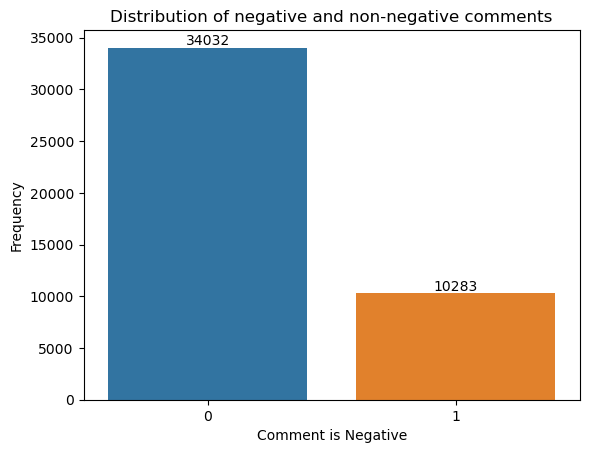

In [38]:
# Create the bar plot
ax = sns.barplot(x=distribution.index, y=distribution.values)
plt.xlabel('Comment is Negative')
plt.ylabel('Frequency')
plt.title('Distribution of negative and non-negative comments')

# Add frequency labels on top of the bars
for index, value in enumerate(distribution.values):
    ax.text(index, value, str(value), ha='center', va='bottom')

plt.show()

*Interpretation: There is a class imbalance, with non-negative comments being three times as common as negative comments.*

Based on our EDA, we clearly cannot answer our problem statement, which is 'Can we create an effective classification model to identify the level of negative sentiment in text comments?'. Thus, we will create a model in Notebook 3.

In [39]:
# Saving file for next notebook
with open('../data/02_Labelled_Data.pickle', 'wb') as file:
    pickle.dump(df, file)